In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from Tryba_Functions import scatter_with_subplots

# Data Import

In [9]:
# create dataframe
project_hours = pd.read_csv('project_hours_scaled.csv')

# change date columns to datetime
project_hours[['fund_date', 'start_date', 'finish_date']] = project_hours[['fund_date', 'start_date', 'finish_date']].astype('datetime64[s]')
project_hours[['client_id', 'project_id']] = project_hours[['client_id', 'project_id']].astype('int')

# Exploratory Analysis

## Pricing Visualizations


In [8]:
# Filter 'project_hours' by projects that are marked 'Done'

project_hours_tracked_paid = project_hours[(project_hours['status'].str.lower() == 'done') 
                                      & (project_hours['time_tracked'] == True)
                                      & (project_hours['spec_project'] == False)] 
project_hours_done_full_production_paid = project_hours[(project_hours['project_type'].str.lower() == 'full production') 
                                                       & (project_hours['status'].str.lower() == 'done')
                                                       & (project_hours['spec_project'] == False)
                                                       & (project_hours['time_tracked'] == True)]

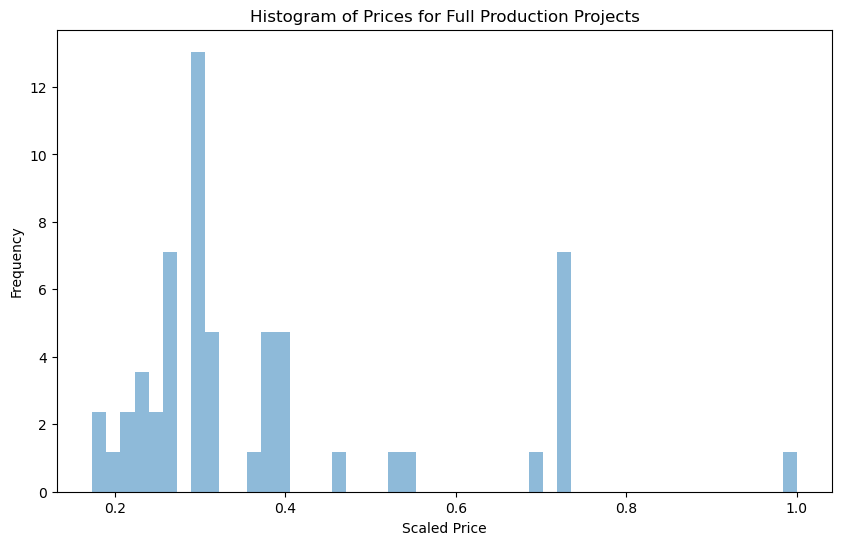

In [4]:
#Histogram of prices on finished full production projects

plt.figure(figsize=(10,6))
plt.hist(project_hours_done_full_production_paid['price'], density=True, bins=50, alpha = 0.5)

ax = plt.subplot()
title = 'Histogram of Prices for Full Production Projects'
plt.title(title)
plt.xlabel('Scaled Price')
plt.ylabel('Frequency')
plt.savefig(os.path.join('Visualizations', title))
plt.show()

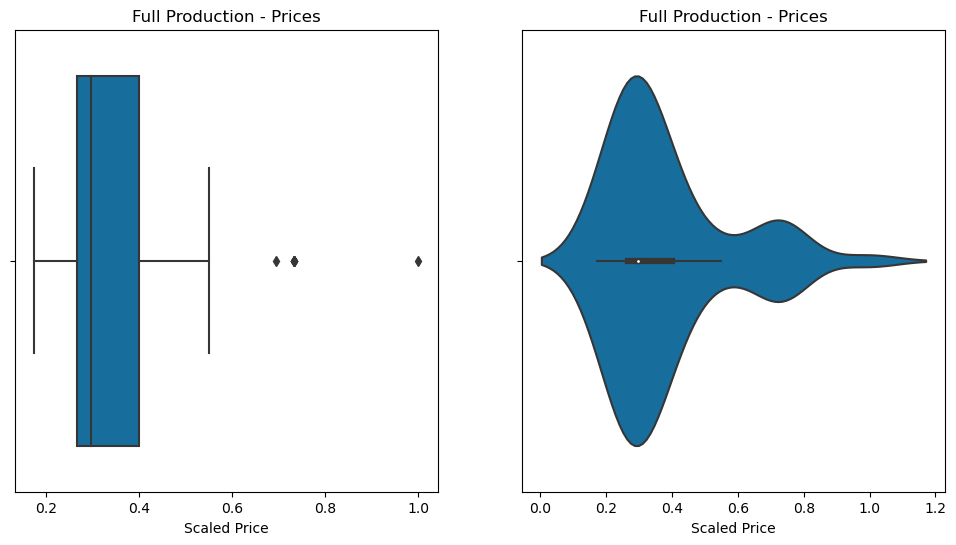

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')

plt.subplot(1,2,2)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.violinplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')
title = 'Full Production Prices Box and Violin Plots'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

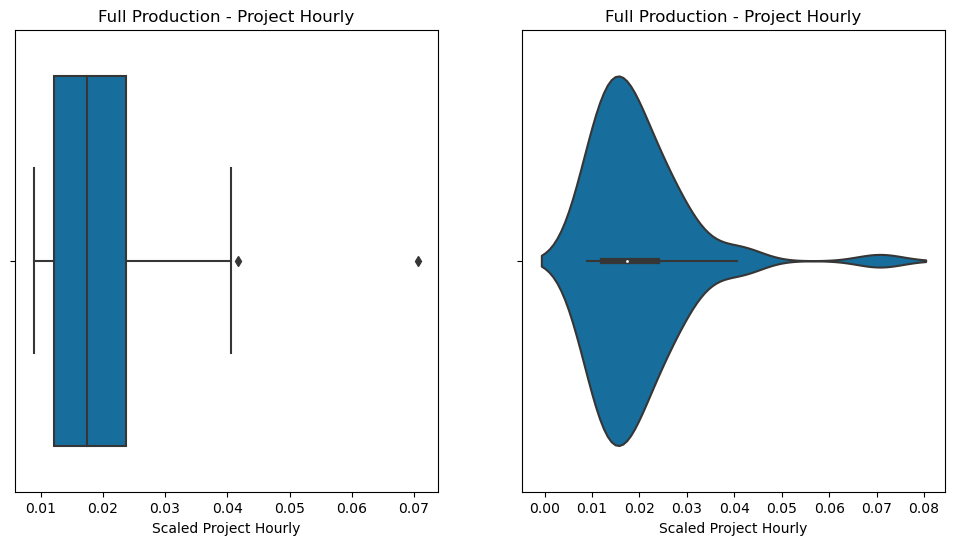

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')

plt.subplot(1,2,2)
sns.violinplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')
title = 'Full Production Project Hourly Box and Violin Plots'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

ValueError: array must not contain infs or NaNs

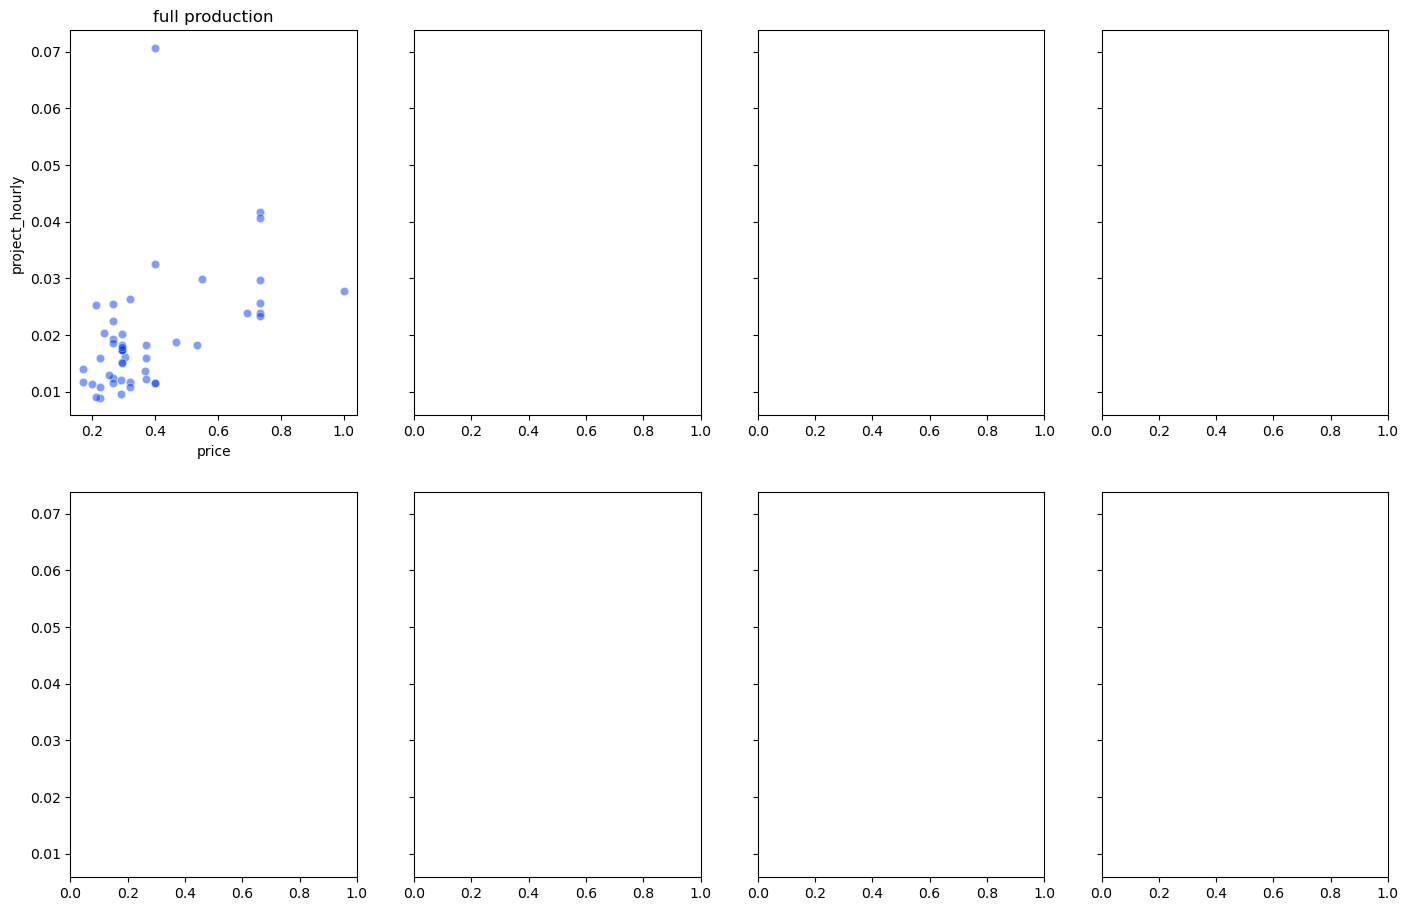

In [7]:
scatter_with_subplots(project_hours_tracked_paid, 'price', 'project_hourly', 'project_type', 'bright', 17, 11, 'Project Hourly vs Price by Production Type')

ValueError: array must not contain infs or NaNs

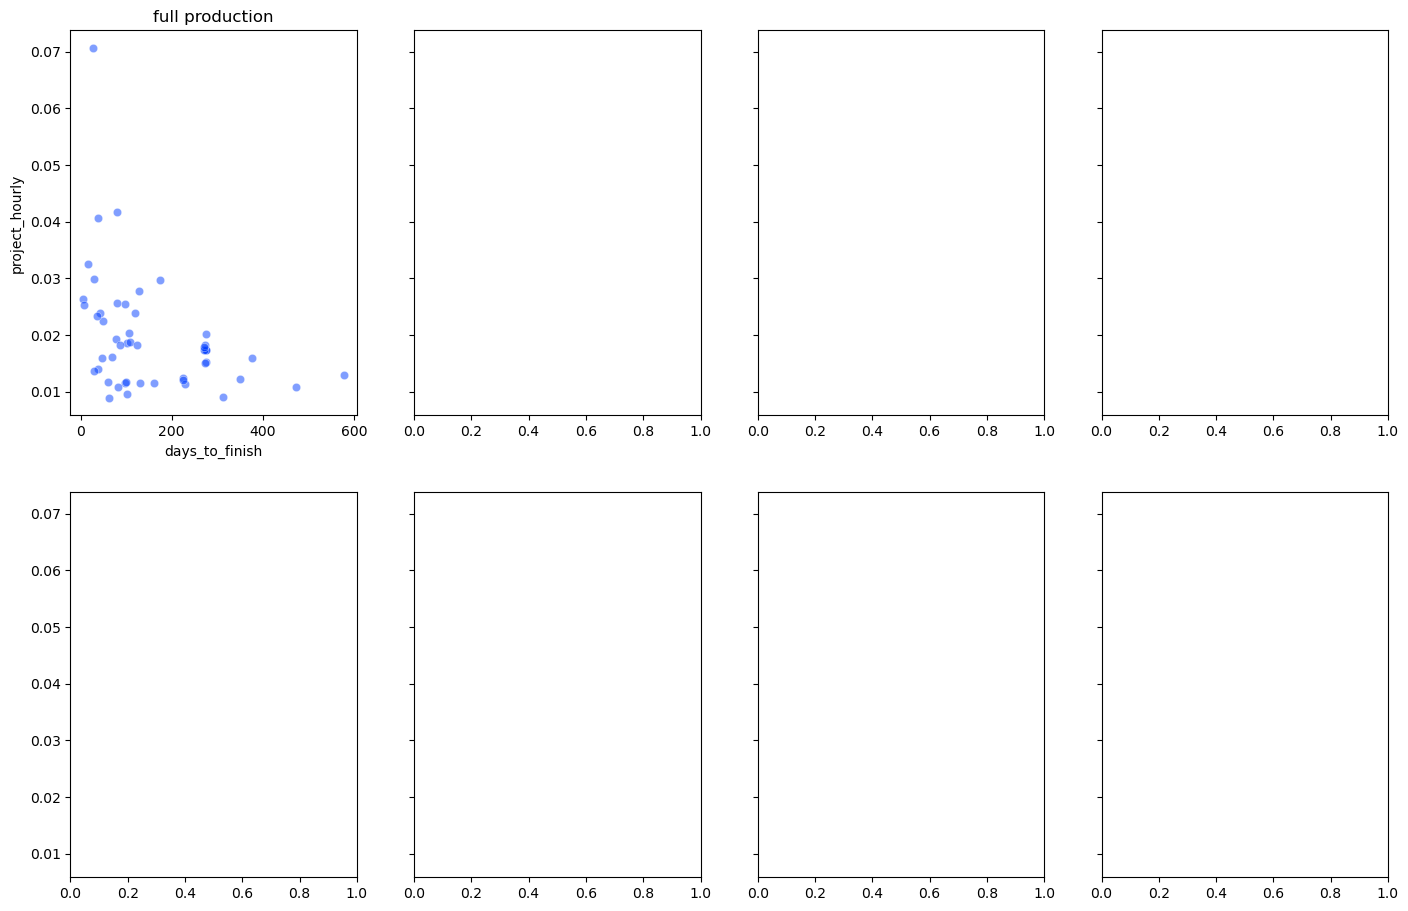

In [10]:
# Is there a correlation between days to finish a project and project hourly?
scatter_with_subplots(project_hours_tracked_paid, 'days_to_finish', 'project_hourly', 'project_type', 'bright', 17, 11, 'Project Hourly vs Days to Finish by Project Type')

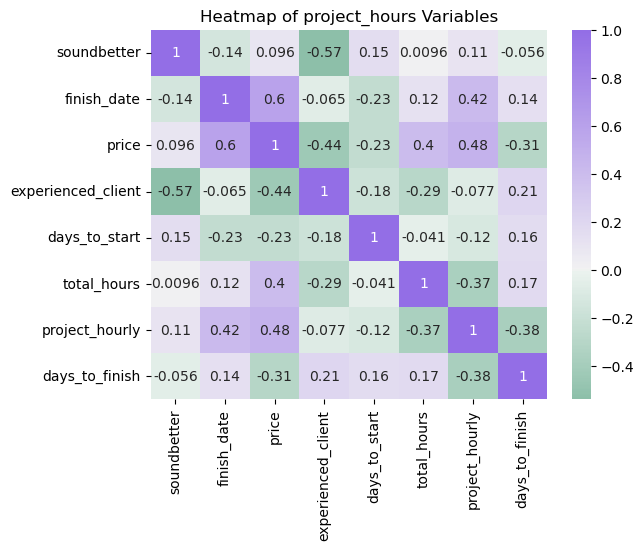

In [ ]:
# Heatmap of project_hours_done
colors = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
# Create heatmap using the .corr method on df, set colormap to cmap
sns.heatmap(project_hours_done_full_production_paid[['soundbetter', 'finish_date', 'price', 'experienced_client', 'days_to_start',
                                'total_hours', 'project_hourly', 'days_to_finish']].corr(), center=0, cmap=colors, robust=True, annot=True)
title = 'Heatmap of project_hours Variables'
plt.title(title)
plt.savefig(os.path.join('Visualizations', title))
plt.show()

/Users/matthewtryba/anaconda3/envs/tryba-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


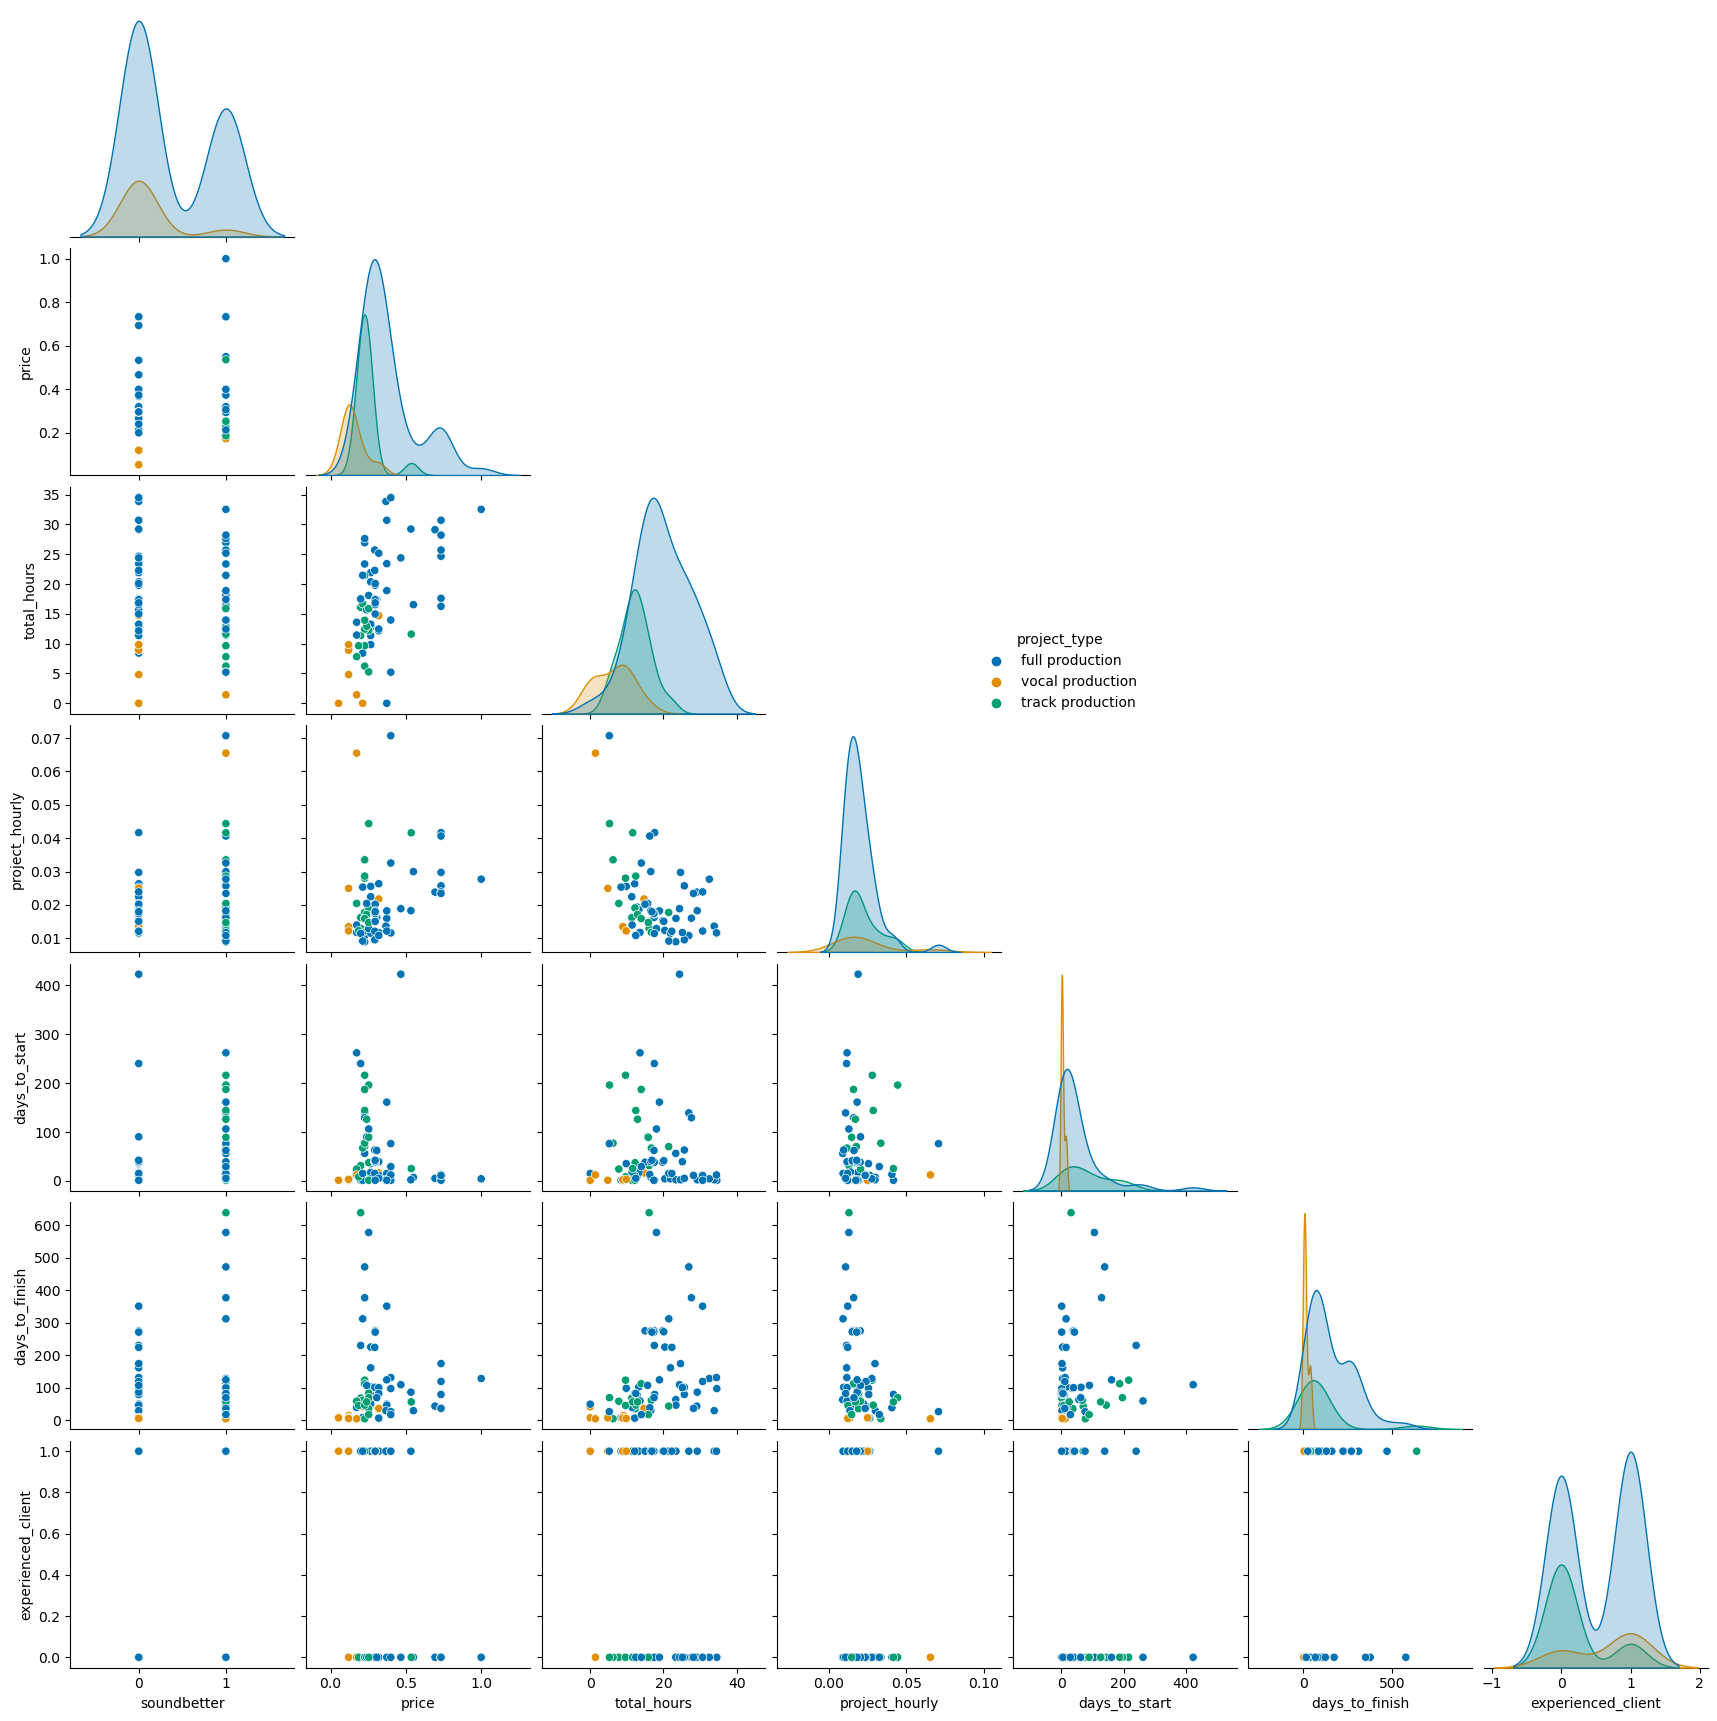

In [ ]:
# pairplot different project types to screen for possible correlations
activity_list = ['full production', 'vocal production', 'track production']
project_hours_done_filtered_project_type = project_hours_tracked_paid[project_hours_tracked_paid['project_type'].isin(activity_list)]

plot_data = project_hours_done_filtered_project_type[['soundbetter', 'fund_date', 'finish_date', 'price', 
                                                      'project_type', 'total_hours', 'project_hourly', 'days_to_start', 'days_to_finish', 'experienced_client']]

#Create Pairplots
pair_plot = sns.pairplot(plot_data, hue='project_type', palette='colorblind', corner=True)
pair_plot._legend.set_bbox_to_anchor((0.6, 0.6))  # Adjust the position of the legend
pair_plot.tight_layout()
title = 'Pairplot of project_hours'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

## Analyzing Days Between Project Funding

In [ ]:
# Create and filter dataframe
fund_dates = project_hours[['fund_date', 'total_after_fees', 'client_id']]
fund_dates = fund_dates.sort_values(by='fund_date', ascending=True).reset_index(drop = True)
fund_dates = fund_dates[fund_dates['fund_date'] > '2018-12-31']
fund_dates['days_between'] = 0
fund_dates['deposit'] = round(fund_dates['total_after_fees']/2, 2)

# iterate through fund_date and calculate the days between each successive date
for i in range(len(fund_dates)):
    if i == 0:
        fund_dates.loc[i, 'days_between'] = 0
    else:
        fund_dates.loc[i, 'days_between'] = (fund_dates.loc[i, 'fund_date'] - fund_dates.loc[i-1, 'fund_date']).days

fund_dates.head()

,fund_date,total_after_fees,client_id,days_between,deposit
1,2019-09-03,0.459627,20.0,NaN,0.23
2,2019-10-10,0.221064,44.0,37.0,0.11
3,2019-12-09,0.208784,4.0,60.0,0.10
4,2020-01-16,0.294752,58.0,38.0,0.15
5,2020-02-13,0.233347,19.0,28.0,0.12


In [ ]:
''' I need to figure out how to combine rows into one sum if the artist is the same name on a given fund date
to address projects that had multiple songs funded that day'''

agg_dict = {
    'total_after_fees': 'sum',
    'days_between': 'first'  # You can use 'first' to carry the first value of days_between
}

collapsed_fund_dates = fund_dates.groupby(['fund_date', 'client_id'], as_index=False).agg(agg_dict)
collapsed_fund_dates['deposit'] = round(collapsed_fund_dates['total_after_fees']/2, 2)
collapsed_fund_dates.head()

,fund_date,client_id,total_after_fees,days_between,deposit
0,2019-09-03,20.0,0.459627,NaN,0.23
1,2019-10-10,44.0,0.221064,37.0,0.11
2,2019-12-09,4.0,0.208784,60.0,0.10
3,2020-01-16,58.0,0.294752,38.0,0.15
4,2020-02-13,19.0,0.233347,28.0,0.12


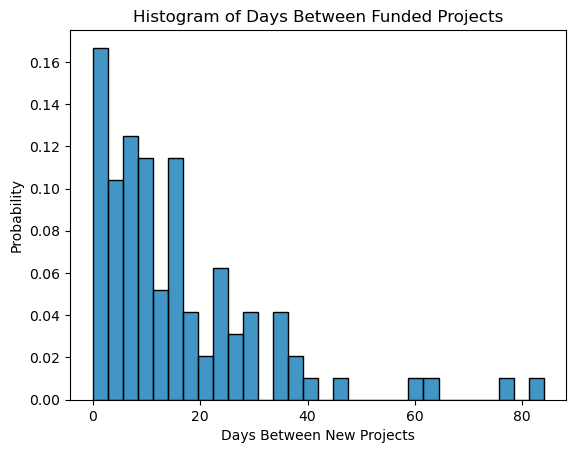

In [ ]:
sns.histplot(data = collapsed_fund_dates, x = 'days_between', bins = 30, kde=False,stat='probability')
plt.style.use('default')
title = 'Histogram of Days Between Funded Projects'
plt.title(title)
plt.xlabel('Days Between New Projects')
plt.savefig(os.path.join('Visualizations', title))
plt.show()

In [ ]:
collapsed_fund_dates.head()

,fund_date,client_id,total_after_fees,days_between,deposit
0,2019-09-03,20.0,0.459627,NaN,0.23
1,2019-10-10,44.0,0.221064,37.0,0.11
2,2019-12-09,4.0,0.208784,60.0,0.10
3,2020-01-16,58.0,0.294752,38.0,0.15
4,2020-02-13,19.0,0.233347,28.0,0.12


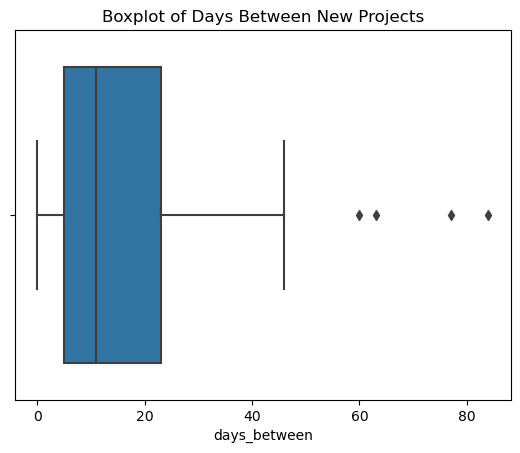

Median is 11.0 and mean is 15.666666666666666


In [ ]:
sns.boxplot(data = collapsed_fund_dates, x= 'days_between')
title = 'Boxplot of Days Between New Projects'
plt.title(title)
plt.savefig(os.path.join('Visualizations', title))
plt.show()

median_days = collapsed_fund_dates['days_between'].median()
mean_days = collapsed_fund_dates['days_between'].mean()

print(f'Median is {median_days} and mean is {mean_days}')

#### Create bar graph with filler dates to visualize frequency of deposits

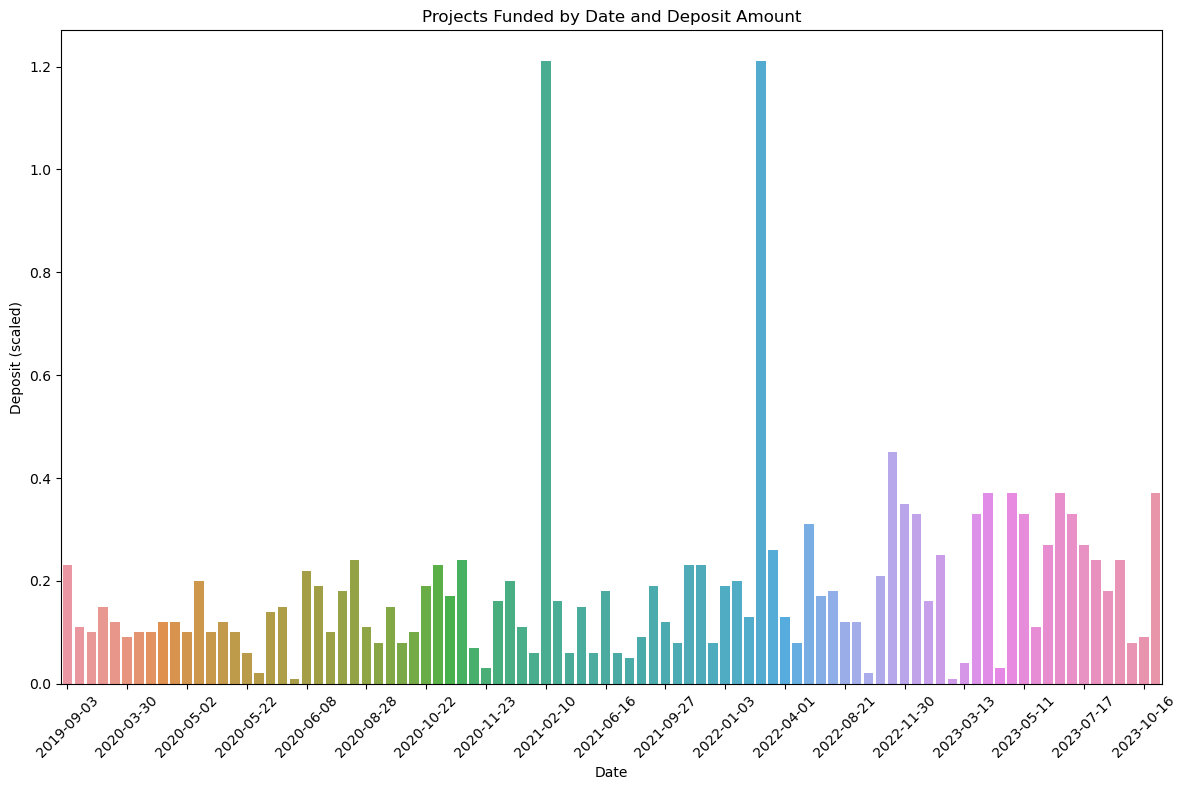

In [ ]:
# Bar Graph without filler dates

funding_money_in = collapsed_fund_dates.groupby('fund_date')['deposit'].sum().reset_index()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data= funding_money_in, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(funding_money_in), 5)  # Show every nth date
x_tick_labels = funding_money_in.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)
title = 'Projects Funded by Date and Deposit Amount'
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Deposit (scaled)')
plt.tight_layout()
plt.savefig(os.path.join('Visualizations', title))
plt.show()

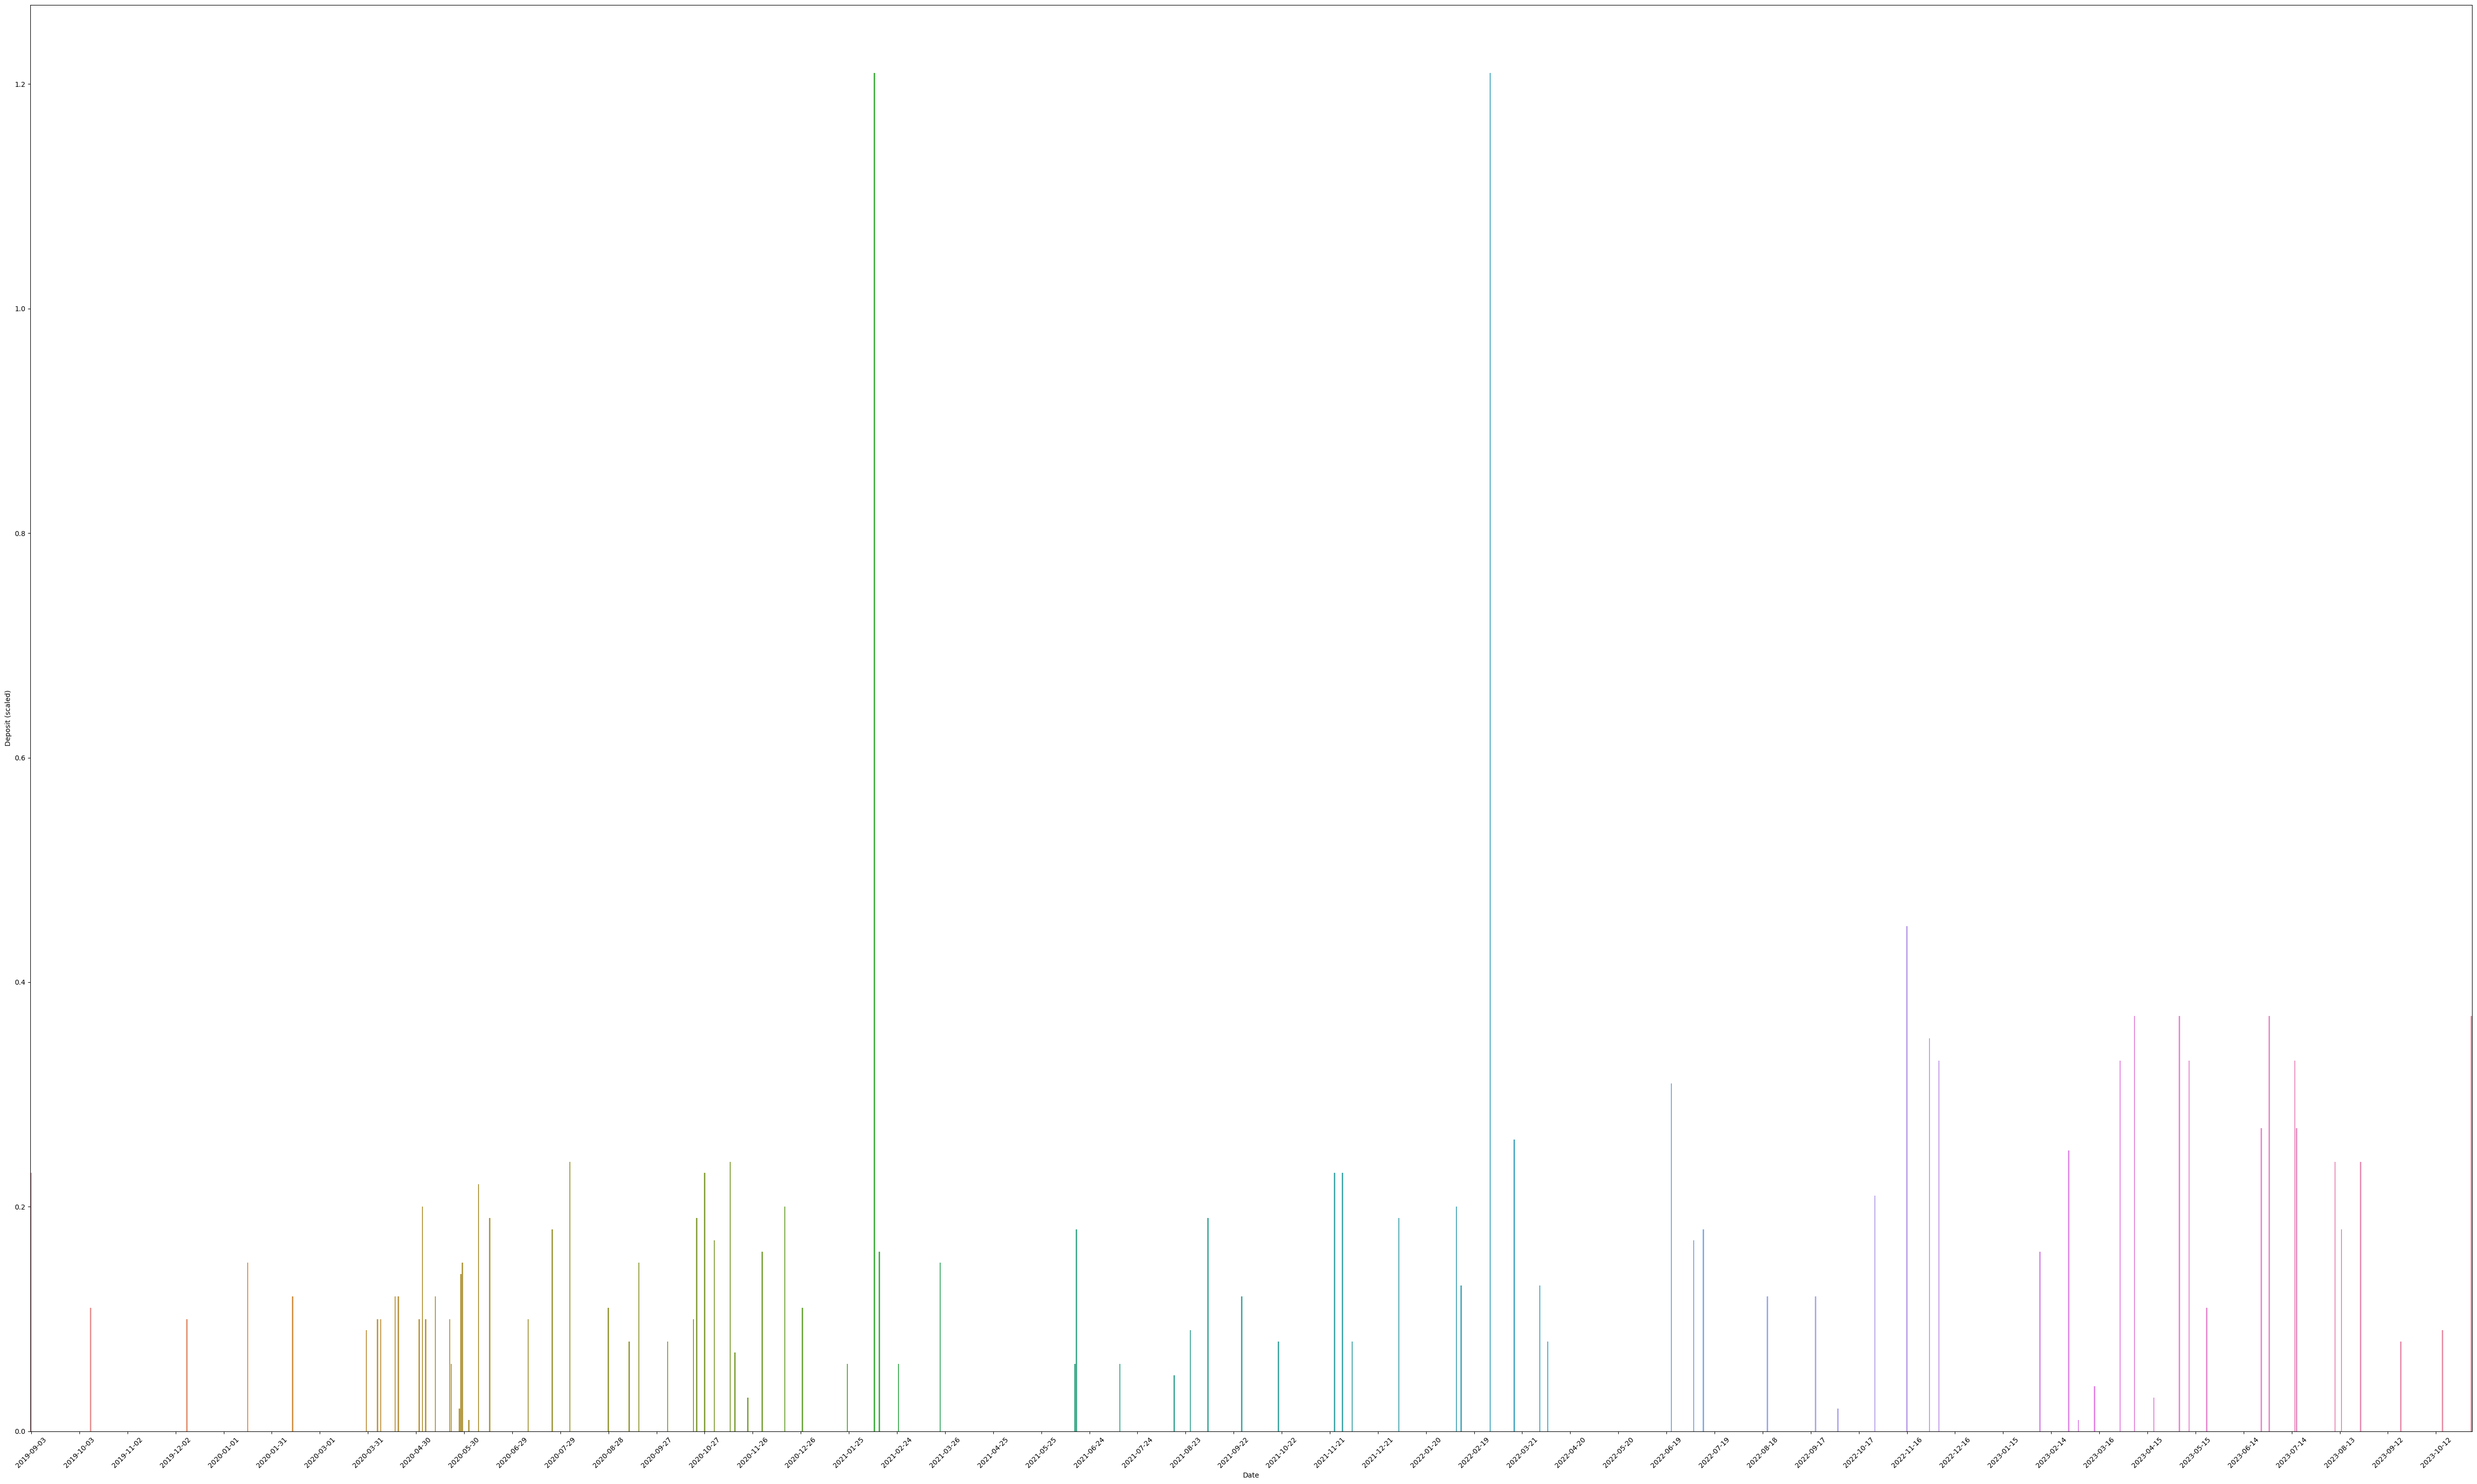

In [ ]:
# The below graph gives a sense of how the deposits are spread through time

# Determine Date Range
fund_date_min = fund_dates['fund_date'].min()
fund_date_max = fund_dates['fund_date'].max()
date_range = pd.date_range(start = fund_date_min, end = fund_date_max, freq='D')

# Create dataframe of just dates within range
temp_df = pd.DataFrame({'fund_date': date_range})

# Left merge data frames on 'fund_date' and fill missing with 0
new_calendar_df = temp_df.merge(funding_money_in, on='fund_date', how='left').fillna(0)

# create figure
plt.figure(figsize=(50, 30)) # needs to be very large in order to see bars
ax = sns.barplot(data= new_calendar_df, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(new_calendar_df), 30)  # Show every nth date
x_tick_labels = new_calendar_df.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)
title = 'Projects Funded By Date with Filler Days'
plt.xlabel('Date')
plt.ylabel('Deposit (scaled)')
plt.tight_layout()
plt.savefig(os.path.join('Visualizations', title))
plt.show()

# Evaluating 'Business Hunches'

## How likely is a Soundbetter Client to be experienced?

Null hypothesis: there is no association between a client being from Soundbetter and their experience level.

In [ ]:
# Create crosstab
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'])

chi2, pval, dof, expected = chi2_contingency(Xtab)
print(f'The p-value is {pval}')

The p-value is 6.000347675463873e-27


In [ ]:
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'], normalize = True).reset_index()
Xtab

experienced_client,soundbetter,False,True
0,False,0.068376,0.645299
1,True,0.235043,0.051282


In [ ]:
# sns.scatterplot(x = 'experienced_client', y = 'soundbetter', data=project_hours)
# plt.show()

## Predicting Difficult Clients

### K Nearest Neighbor Classifier

In [ ]:
# pre-processing the data

#make a copy of the dataframe

# desired columns
column_list = ['price','project_type', 'soundbetter', 'songwriter', 'experienced_client', 'backend_belief']
client_difficulty_data = project_hours_tracked_paid[column_list].copy()

# get labels array
client_difficulty_labels = np.array(project_hours_tracked_paid['difficult_client'])
# convert array to binary
client_difficulty_labels = client_difficulty_labels.astype(int)

#MinMax the 'price' column
price_reshaped = np.array(client_difficulty_data['price']).reshape(-1,1)
mmscaler = MinMaxScaler()

# add column of normalized price back to dataframe
client_difficulty_data['price_normalized'] = mmscaler.fit_transform(price_reshaped)



In [ ]:
# one hot encode project type
ohe = pd.get_dummies(client_difficulty_data['project_type'])
client_difficulty_data = client_difficulty_data.join(ohe)

In [ ]:
# cast boolean values as integers
columns_to_cast_as_int = ['soundbetter', 'experienced_client', 'backend_belief', 'additional production',
                          'full production', 'mastering', 'mixing', 'pre production', 'production tweak',
                          'track production', 'vocal production', 'songwriter']

client_difficulty_data[columns_to_cast_as_int] = client_difficulty_data[columns_to_cast_as_int].astype(int)

# drop extra columns

client_difficulty_data = client_difficulty_data.drop(['price', 'project_type'], axis=1)

In [ ]:
#k_nn_client_difficulty_data.info()

In [ ]:
# Split the data
training_data, validation_data, training_labels, validation_labels = train_test_split(client_difficulty_data, client_difficulty_labels, test_size=0.2, random_state=100)

print(len(training_data), len(training_labels)) # verify the length is the same

68 68


In [ ]:
scores = [] # initiate blank list

for k in range(1,20): # loop through k from 1 to 100 and append the scores to the list
    classifier = KNeighborsClassifier(n_neighbors = k) # create a classifier with k neighbors
    classifier.fit(training_data, training_labels) # train the classifier
    scores.append(classifier.score(validation_data, validation_labels)) # determine the accuracy of the trained classifier

print(scores)

max_score = max(scores) # determine the max score
max_score_index = scores.index(max_score) # find the index of max score
print(max_score, max_score_index + 1) # add 1 to index to find k value for max score

''' Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off'''

[0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444]
0.9444444444444444 2


" Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off"